# Time Series Forecasting Tutorial
### by Sithan Kanna

This is a sample tutorial. 

In [34]:
# import relevant panckages 
import pandas as pd
import numpy as np

# Financial data time-series
import quandl

# Plotting parameters
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)

## (Down)Load Time Series Data 

If you do not have the time series, download it. Else just load it from the `data/` directory. 

In [ ]:
## ----- First Time Download of Data ----------- ##
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "GM", "GE"]
series = "Close"
# Available options: Open, High, Low, Close, Volume, Adj. Open, Adj. High, Adj. Low, Adj. Close, Adj. Volume

df_price = pd.DataFrame() 

for stck in tickers:
    data = quandl.Dataset("WIKI/{}".format(stck))\
                 .data(params={"start_date":"2002-01-01", "end_date":"2018-07-01"})\
                 .to_pandas()[[series]]\
                 .rename(columns={series:stck})
    df_price = pd.concat([df_price, data], axis=1)

# Make sure there are no dates without closing prices    
df_price = df_price.dropna()

#  Save data 
df_price.to_pickle("data/df_price.pickle")


## ----- Alternative: Load data from Memory ----------- ##
df_price = pd.read_pickle("data/df_price.pickle")

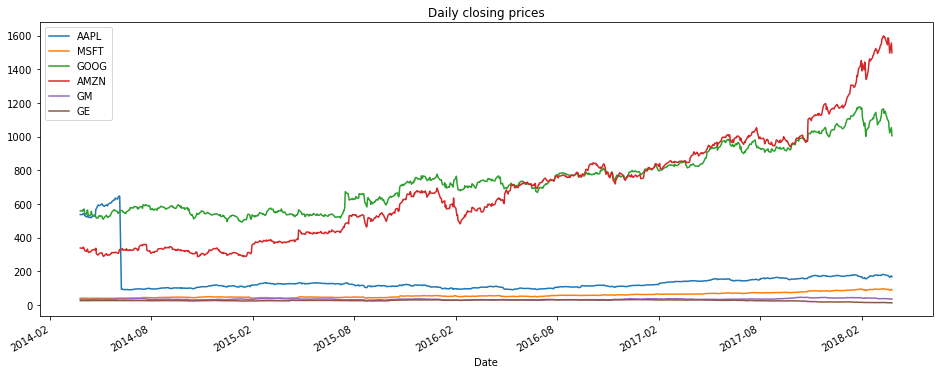

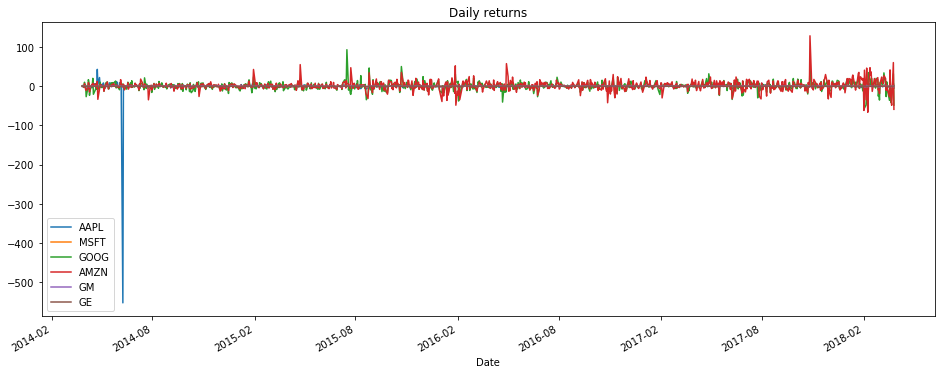

In [35]:
# Visualise Data 
df_price.plot(title="Daily closing prices")
plt.show()

df_price.diff().plot(title="Daily returns")
plt.show()

## Reorganise Data  

## Create Advanced Feature Vectors 